# Analyze the visual embedding space and the semantic embedding space using given categories

In [1]:
import pickle
import pandas as pd
from pathlib2 import Path

In [2]:
embeddings_dir = Path('embeddings')
labels_dir = Path('labels')

## Define useful tools and metrics

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [151]:
def classify_embeddings_with_feature_importances(embeddings, labels, top_feature_bar=0.002):
    # 将数据分为训练集和测试集（通常按照80/20的比例）
    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=699)

    # 初始化随机森林分类器
    clf = RandomForestClassifier(n_estimators=50, random_state=699, criterion='entropy')

    # 使用训练集训练随机森林分类器
    clf.fit(X_train, y_train)

    # 对测试集进行预测
    y_pred = clf.predict(X_test)

    # 计算评估指标
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # 输出评估结果
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # 获取特征重要性
    feature_importances = clf.feature_importances_
    feature_importances = sorted(enumerate(feature_importances), key=lambda x: x[1], reverse=True)
    feature_importances = [(i, importance) for i, importance in feature_importances if importance >= top_feature_bar]
    print("\nFeature Importances:")
    for i, feature_importance in feature_importances:
        print(f"{i:3d}. feature {i:3d} ({feature_importance:.4f})")
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1, 'feature_importances': feature_importances}

In [79]:
def cluster_embeddings(embeddings_array, k):
    kmeans = KMeans(n_clusters=k, random_state=699).fit(embeddings_array)

    # Get the cluster labels and centroids
    cluster_labels = kmeans.labels_
    cluster_centroids = kmeans.cluster_centers_

    return cluster_labels, cluster_centroids

In [5]:
def analyze_label_relationship(labels1, labels2):
    # Calculate the Adjusted Rand Index
    ari = adjusted_rand_score(labels1, labels2)

    # Calculate the Normalized Mutual Information
    nmi = normalized_mutual_info_score(labels1, labels2)

    # Calculate the Contingency Matrix (confusion matrix)
    cm = confusion_matrix(labels1, labels2)
    
    # Sum the maximum values of each row
    max_values_sum = np.sum(np.amax(cm, axis=1))
    
    # Calculate purity
    purity = max_values_sum / np.sum(cm)

    return ari, nmi, purity, cm


In [6]:
def tsne_plot(embeddings, labels, labels_index_dict):
    tsne = TSNE(n_components=2,
                learning_rate='auto',
                init='random',
                perplexity=3,
                random_state=699)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Create a list of unique categories and their colors
    unique_labels = list(set(labels))
    colors = colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    # Plot the t-SNE
    plt.figure(figsize=(10, 8))
    for label, color in zip(unique_labels, colors):
        filter = labels == label
        plt.scatter(embeddings_2d[filter, 0],
                    embeddings_2d[filter, 1],
                    c=[color],
                    label=labels_index_dict[label],
                    s=5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [7]:
def cm_heat_plot(cm, label_index_dict):
    # Create a list of unique categories and their colors
    row_sums = cm.sum(axis=1, keepdims=True)
    normalized_cm = cm / row_sums

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(normalized_cm, annot=True, cmap='Reds', fmt='.2f', xticklabels=label_index_dict.values(), yticklabels=label_index_dict.values())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [8]:
def analyze(labels, embeddings, label_index_dict, plot=True):
    k = len(set(labels))
    print('Begin clustering with k =', k)
    cluster_labels, cluster_centroids = cluster_embeddings(embeddings, k)
    print('Clustering complete.')
    ari, nmi, purity, cm = analyze_label_relationship(labels, cluster_labels)
    
    random_labels = np.random.randint(0, k, len(labels))
    r_ari, r_nmi, r_purity, r_cm = analyze_label_relationship(labels, random_labels)
    
    print("Adjusted Rand Index:", ari, "random ones:", r_ari)
    print("Normalized Mutual Information:", nmi, "random ones:", r_nmi)
    print('Purity:', purity, "random ones:", r_purity)
    print("Contingency Matrix (confusion matrix):\n")
    
    if plot:
        cm_heat_plot(cm, label_index_dict)
        tsne_plot(embeddings, labels, label_index_dict)
    
    return ari, nmi, purity,  cluster_centroids, cluster_labels
    

In [9]:
def align_labels(labels_df, embeddings):
    common_hanzi = set(labels_df['Hanzi'].values).intersection(set(embeddings.keys()))
    labels = labels_df[labels_df['Hanzi'].isin(common_hanzi)]['label_index'].values
    result_embeddings = np.array([embeddings[hanzi] for hanzi in common_hanzi])
    return labels, result_embeddings

In [10]:
def create_balanced_dataset(df, label_column, samples_per_label=None):
    """
    Creates a relatively balanced dataset by sampling a specified number of samples per label.

    :param df: A pandas DataFrame containing the data.
    :param label_column: The name of the column containing the labels.
    :param samples_per_label: The number of samples to sample per label. If None, sample all available samples.
    :return: A new DataFrame containing the balanced dataset.
    """
    unique_labels = df[label_column].unique()
    dfs = []

    for label in unique_labels:
        label_df = df[df[label_column] == label]

        if samples_per_label is not None:
            label_df = label_df.sample(min(samples_per_label, len(label_df)), random_state=699)

        dfs.append(label_df)

    # Concatenate the DataFrames and shuffle the rows
    balanced_df = pd.concat(dfs).sample(frac=1, random_state=699).reset_index(drop=True)

    return balanced_df

## Analyze Visual Embeddings

In [28]:
visual_labels_df = pd.read_csv(labels_dir / 'visual_labels_cleaned.csv')
visual_label_index_dict = pickle.load(open(labels_dir / 'visual_labels_index_dict.pkl', 'rb'))
visual_labels_df.head()

Hanzi     Structure  label_index
0     一  Unicomponent            0
1     乙  Unicomponent            0
2     二  Unicomponent            0
3     十  Unicomponent            0
4     丁  Unicomponent            0

### Visual embeddings

In [152]:
visual_embeddings = pickle.load(open(embeddings_dir / 'visual_embeddings.pkl', 'rb'))
visual_labels, visual_embeddings = align_labels(visual_labels_df, visual_embeddings)

Begin clustering with k = 14
Clustering complete.
Adjusted Rand Index: 0.0001648945245056477 random ones: 0.00028276728918106626
Normalized Mutual Information: 0.018221133149780296 random ones: 0.021835635269164693
Purity: 0.12 random ones: 0.0984
Contingency Matrix (confusion matrix):



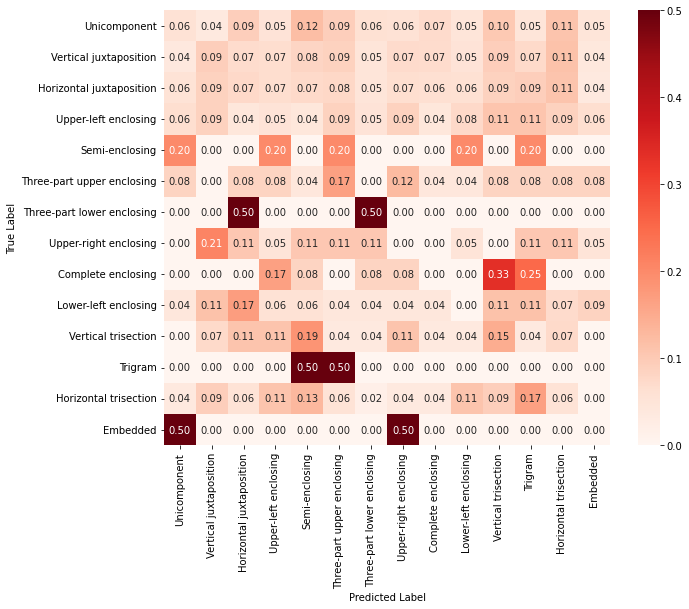

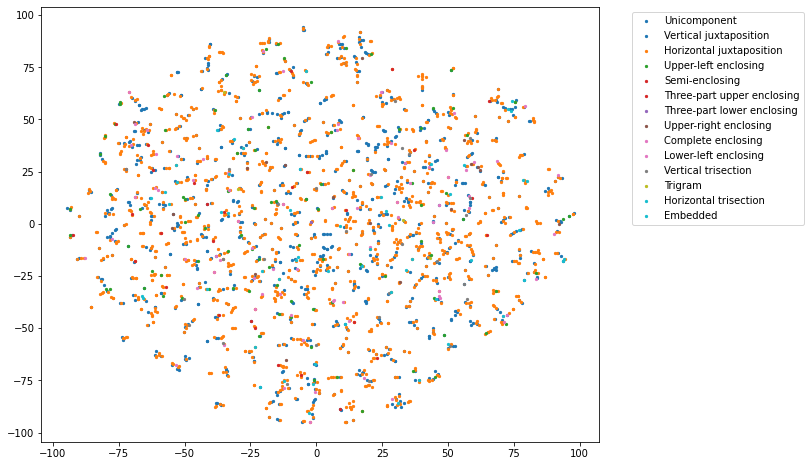

In [153]:
ari, nmi, purity, cluster_centroids, cluster_labels = analyze(visual_labels, visual_embeddings, visual_label_index_dict)

In [154]:
resutls = classify_embeddings_with_feature_importances(visual_embeddings, visual_labels)

Accuracy: 0.56
Precision: 0.07
Recall: 0.08
F1 Score: 0.07

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.22      0.04      0.07       123
           2       0.58      0.96      0.72       287
           3       0.00      0.00      0.00        21
           5       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        15
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00         1

    accuracy                           0.56       500
   macro avg       0.07      0.08      0.07       500
weighted avg       0.38      0.56      0.43       500


Feature Importances:
498. feature 498 (0.0026)
4

/Users/zhangjunjie/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zhangjunjie/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zhangjunjie/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zhan

In [155]:
feature_index = [i for i, _ in resutls['feature_importances']]
visual_embeddings = visual_embeddings[:, feature_index]
visual_embeddings.shape

(2500, 16)

Begin clustering with k = 14
Clustering complete.
Adjusted Rand Index: -0.0005567980050240227 random ones: 0.0005099446019959284
Normalized Mutual Information: 0.019401319937635497 random ones: 0.019032488930965392
Purity: 0.1428 random ones: 0.1012
Contingency Matrix (confusion matrix):



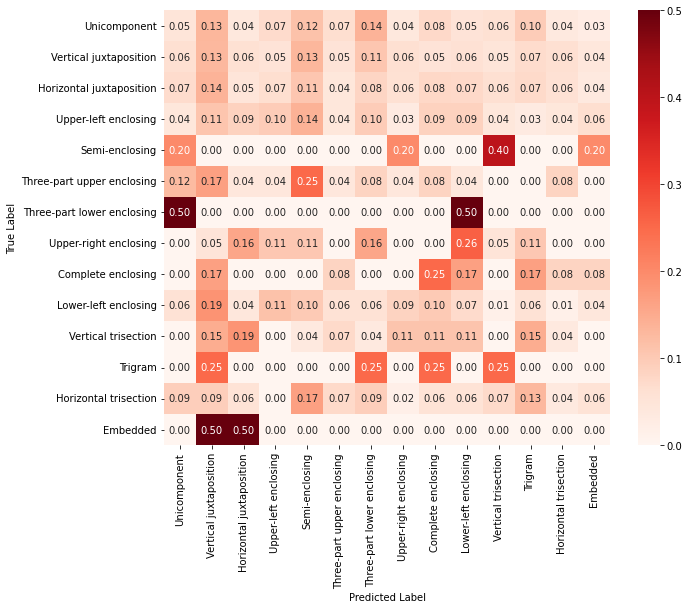

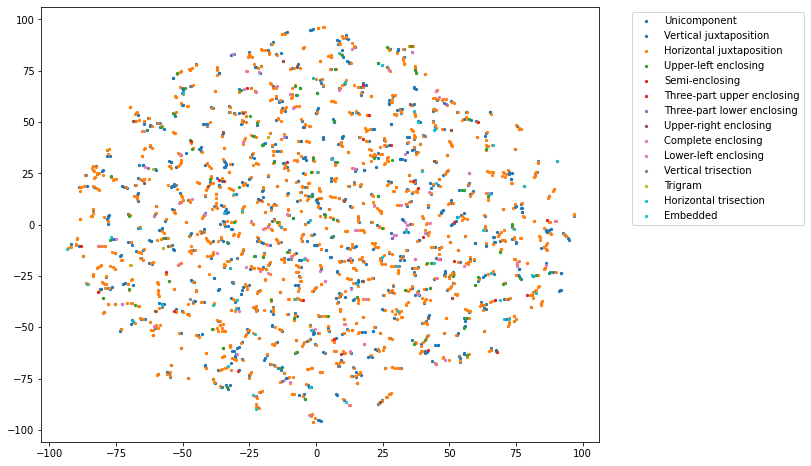

In [156]:
ari, nmi, purity, cluster_centroids, cluster_labels = analyze(visual_labels, visual_embeddings, visual_label_index_dict)

### Text embeddings

In [158]:
text_embeddings = pickle.load(open(embeddings_dir / 'text_embeddings.pkl', 'rb'))
visual_labels, text_embeddings = align_labels(visual_labels_df, text_embeddings)

Begin clustering with k = 14
Clustering complete.
Adjusted Rand Index: -0.001041321434854109 random ones: -0.00020111724502217397
Normalized Mutual Information: 0.014526560916647061 random ones: 0.016136630057712622
Purity: 0.2008 random ones: 0.0908
Contingency Matrix (confusion matrix):



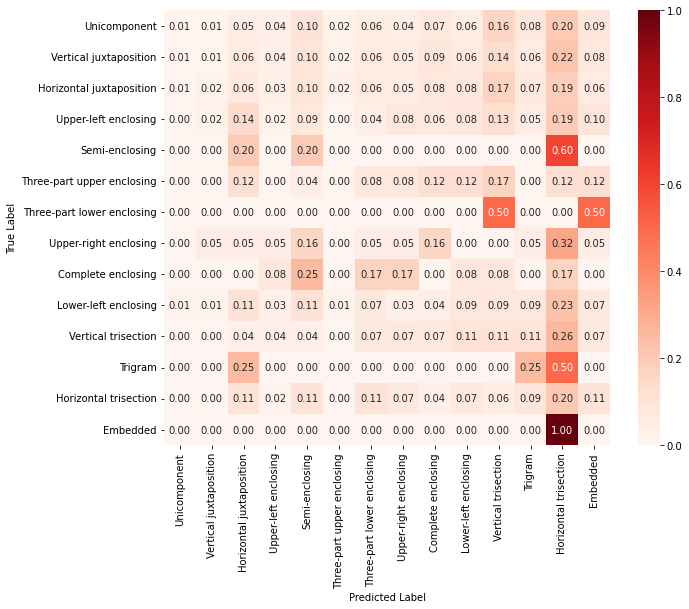

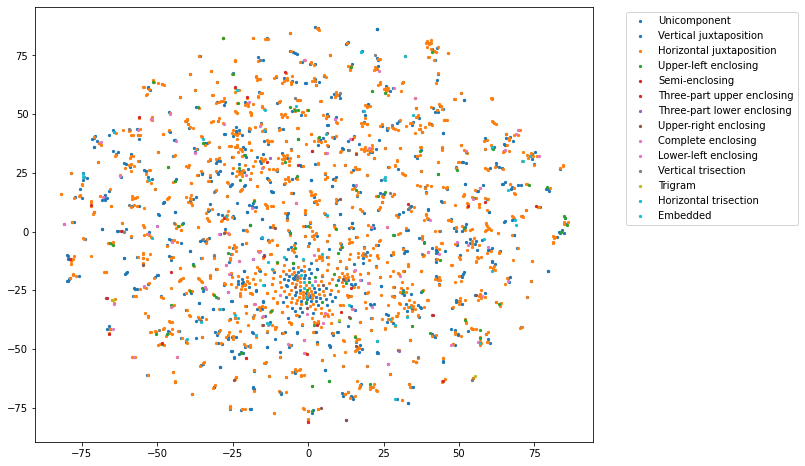

In [159]:
ari, nmi, purity, cluster_centroids, cluster_labels = analyze(visual_labels, text_embeddings, visual_label_index_dict)

In [160]:
resutls = classify_embeddings_with_feature_importances(text_embeddings, visual_labels)

Accuracy: 0.55
Precision: 0.07
Recall: 0.08
F1 Score: 0.07

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.24      0.05      0.08       123
           2       0.57      0.94      0.71       287
           3       0.00      0.00      0.00        21
           5       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        15
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00         1

    accuracy                           0.55       500
   macro avg       0.07      0.08      0.07       500
weighted avg       0.39      0.55      0.43       500


Feature Importances:
362. feature 362 (0.0027)
6

/Users/zhangjunjie/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zhangjunjie/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zhangjunjie/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zhan

In [161]:
feature_index = [i for i, _ in resutls['feature_importances']]
text_embeddings = text_embeddings[:, feature_index]
text_embeddings.shape

(2500, 32)

Begin clustering with k = 14
Clustering complete.
Adjusted Rand Index: -0.000716369090602091 random ones: -0.0002249175324648048
Normalized Mutual Information: 0.015313033373862377 random ones: 0.017526887421867185
Purity: 0.1048 random ones: 0.0936
Contingency Matrix (confusion matrix):



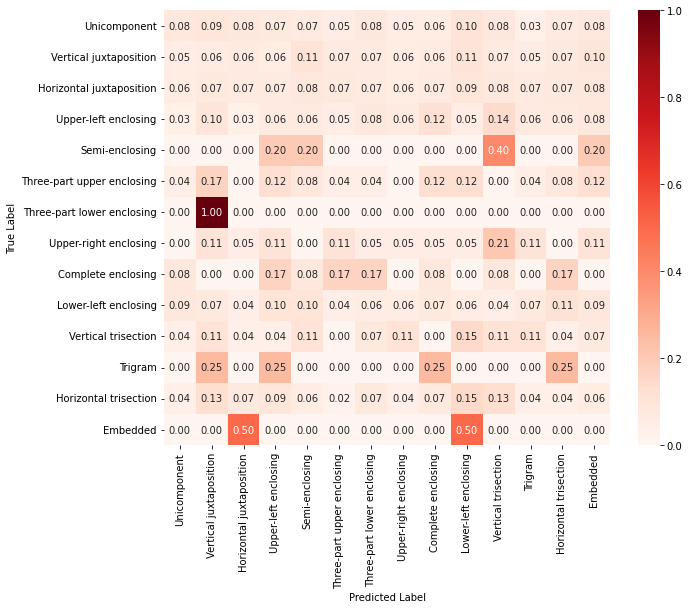

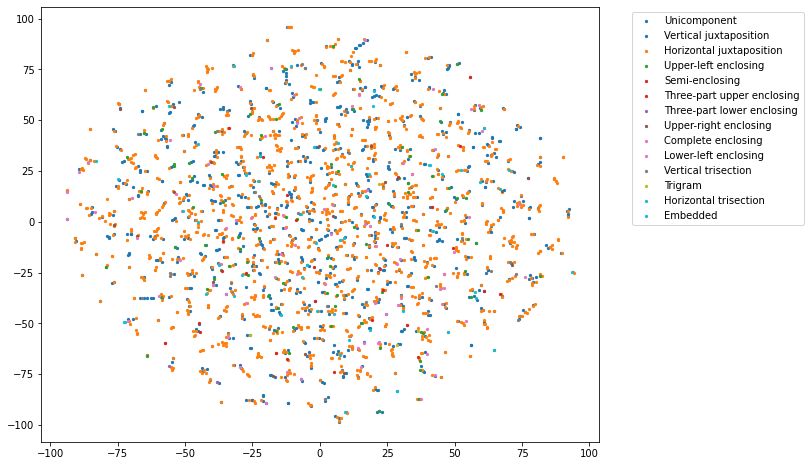

In [162]:
ari, nmi, purity, cluster_centroids, cluster_labels = analyze(visual_labels, text_embeddings, visual_label_index_dict)

### balanced dataset

In [163]:
# count each label
visual_labels_df['Structure'].value_counts()

Horizontal juxtaposition      1321
Vertical juxtaposition         641
Unicomponent                   226
Upper-left enclosing            93
Lower-left enclosing            70
Horizontal trisection           54
Vertical trisection             27
Three-part upper enclosing      24
Upper-right enclosing           19
Complete enclosing              12
Semi-enclosing                   5
Trigram                          4
Three-part lower enclosing       2
Embedded                         2
Name: Structure, dtype: int64

In [164]:
balanced_df = create_balanced_dataset(visual_labels_df, 'label_index', 100)
balanced_df['Structure'].value_counts()

Unicomponent                  100
Horizontal juxtaposition      100
Vertical juxtaposition        100
Upper-left enclosing           93
Lower-left enclosing           70
Horizontal trisection          54
Vertical trisection            27
Three-part upper enclosing     24
Upper-right enclosing          19
Complete enclosing             12
Semi-enclosing                  5
Trigram                         4
Three-part lower enclosing      2
Embedded                        2
Name: Structure, dtype: int64

### visual embedding (banlanced)

In [165]:
visual_embeddings = pickle.load(open(embeddings_dir / 'visual_embeddings.pkl', 'rb'))
visual_labels, visual_embeddings = align_labels(balanced_df, visual_embeddings)

Begin clustering with k = 14
Clustering complete.
Adjusted Rand Index: -0.0035901461669403775 random ones: 0.0002788953993791261
Normalized Mutual Information: 0.05927350764395514 random ones: 0.05655301612692611
Purity: 0.2222222222222222 random ones: 0.1388888888888889
Contingency Matrix (confusion matrix):



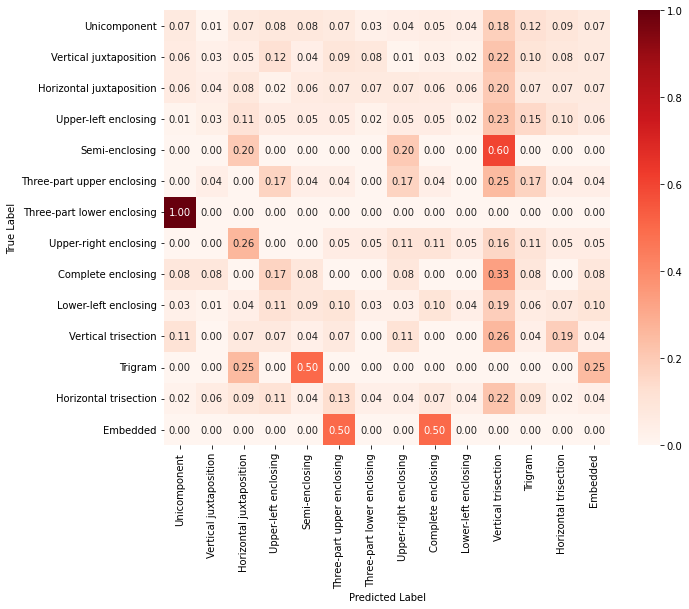

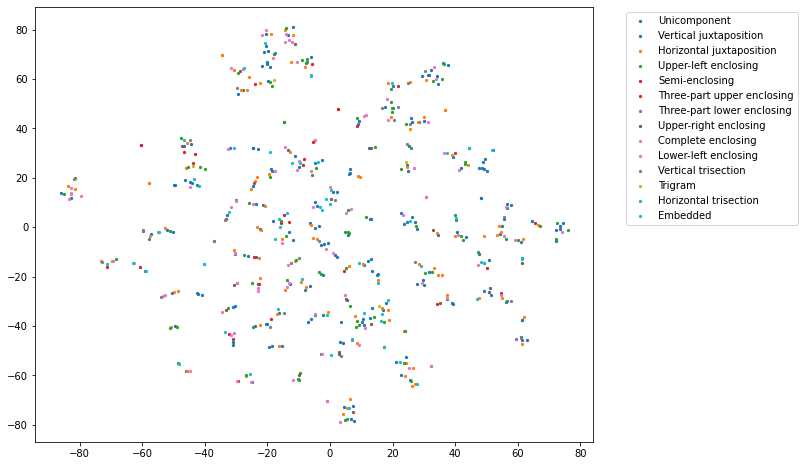

In [166]:
ari, nmi, purity, cluster_centroids, cluster_labels = analyze(visual_labels, visual_embeddings, visual_label_index_dict)

In [167]:
resutls = classify_embeddings_with_feature_importances(visual_embeddings, visual_labels)

Accuracy: 0.15
Precision: 0.08
Recall: 0.09
F1 Score: 0.08

Classification Report:
               precision    recall  f1-score   support

           0       0.11      0.25      0.15        16
           1       0.10      0.21      0.14        19
           2       0.25      0.29      0.27        21
           3       0.23      0.17      0.19        18
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         2
           9       0.29      0.12      0.17        16
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00        15

    accuracy                           0.15       123
   macro avg       0.08      0.09      0.08       123
weighted avg       0.14      0.15      0.14       123


Feature Importances:
118. feature 118 (0.0042)
 

/Users/zhangjunjie/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zhangjunjie/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zhangjunjie/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zhan

### Text embedding (balanced)

In [90]:
text_embeddings = pickle.load(open(embeddings_dir / 'text_embeddings.pkl', 'rb'))
visual_labels, text_embeddings = align_labels(balanced_df, text_embeddings)

Begin clustering with k = 14
Clustering complete.
Adjusted Rand Index: -0.0011029603774354525 random ones: 0.0024826216536540085
Normalized Mutual Information: 0.04669156530478859 random ones: 0.06440472841799032
Purity: 0.3284313725490196 random ones: 0.1454248366013072
Contingency Matrix (confusion matrix):



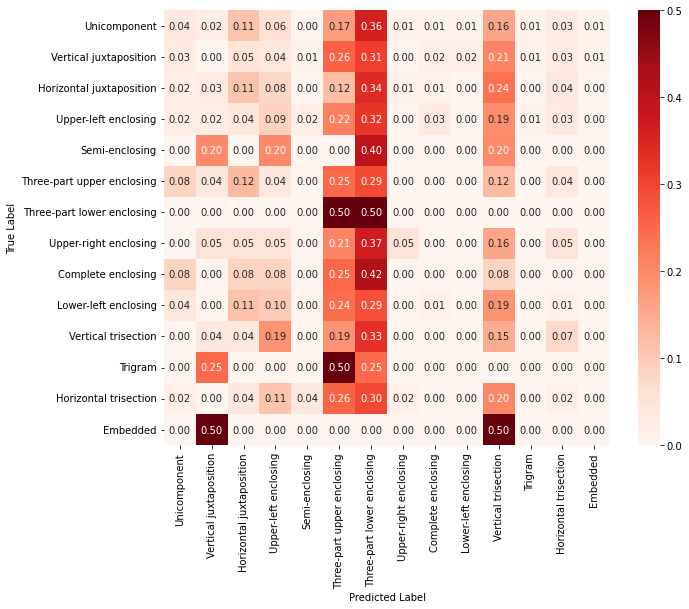

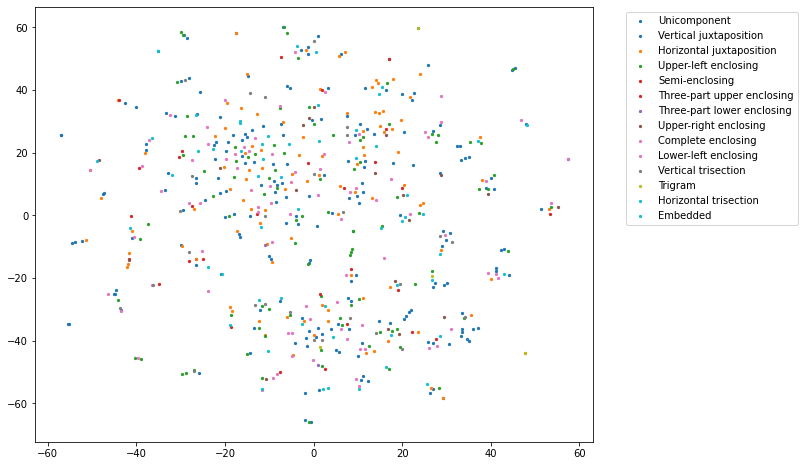

In [91]:
ari, nmi, purity, cluster_centroids, cluster_labels = analyze(visual_labels, text_embeddings, visual_label_index_dict)

## Analyze definition labels

In [171]:
semantic_labels = pd.read_csv(labels_dir / 'semantic_labels_cleaned.csv')
semantic_labels_index_dict = pickle.load(open(labels_dir / 'semantic_labels_index_dict.pkl', 'rb'))

In [172]:
text_embeddings = pickle.load(open(embeddings_dir / 'text_embeddings.pkl', 'rb'))
semantic_labels, text_embeddings = align_labels(semantic_labels, text_embeddings)

In [45]:
ari, nmi, purity, cluster_centroids, cluster_labels = analyze(semantic_labels, text_embeddings, semantic_labels_index_dict, plot=False)

Begin clustering with k = 204
Clustering complete.
Adjusted Rand Index: 0.00018550259201263145 random ones: -7.183420804959374e-05
Normalized Mutual Information: 0.3659346163316324 random ones: 0.37413160028240183
Purity: 0.10445526020217147 random ones: 0.0984649943841258
Contingency Matrix (confusion matrix):



In [174]:
resutls = classify_embeddings_with_feature_importances(text_embeddings, semantic_labels)

Accuracy: 0.09
Precision: 0.00
Recall: 0.01
F1 Score: 0.01

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         1
           3       0.04      0.11      0.05        18
           5       0.14      0.50      0.22        42
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         5
           8       0.04      0.07      0.05        29
          12       0.00      0.00      0.00         6
          13       0.06      0.08      0.07        13
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         5
          19       0.08      0.20      0.11        25
          20       0.00      0.00      0.00        

/Users/zhangjunjie/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zhangjunjie/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zhangjunjie/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zhan